# Examine genetic clines

In [1]:
import os
import allel
import numpy as np
import pandas as pd
import vcf

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

from pathlib import Path
from haversine import haversine
from skbio.stats.distance import mantel

import cartopy.crs as ccrs
import cartopy.feature as cf
from pykrige.ok import OrdinaryKriging

from intervaltree import Interval, IntervalTree


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)

os.chdir(proj_dir)

In [3]:
Path("{}/clines".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/clines".format(results_dir))

In [4]:
#read in sample info
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

#get the pca kmeans groups
pca_df=pd.read_csv("{}/results/pca/pca_df.csv".format(proj_dir), sep=",")
pca_df=pca_df[["sample_name", "kmeans_group", "kmeans_label"]]

#add to the sample info
info_df=info_df.merge(pca_df, how='right', on='sample_name')

## Prep VCF file

- LD filter
- Autosomes

In [5]:
#samples with no lat/lon info cause major problems will need to exclude downstream
sh_nw_samples = info_df.dropna(axis=0, subset=["lat", "lon"]).loc[info_df["kmeans_label"] == "sh_nw", "sample_name" ].values
sh_se_samples = info_df.dropna(axis=0, subset=["lat", "lon"]).loc[info_df["kmeans_label"] == "sh_se", "sample_name" ].values
sb_samples    = info_df.dropna(axis=0, subset=["lat", "lon"]).loc[info_df["kmeans_label"] == "sb", "sample_name" ].values

In [9]:
np.savetxt("sh_nw_samples.list", sh_nw_samples, delimiter=',', fmt="%s")
np.savetxt("sh_se_samples.list", sh_se_samples, delimiter=',', fmt="%s")
np.savetxt("sb_samples.list", sb_samples, delimiter=',', fmt="%s")

In [11]:
%%bash

cat sh_nw_samples.list sh_se_samples.list sb_samples.list >samples.list

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf ../filter_genotypes/sorted_annotated_snps.vcf \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \
        --keep samples.list \
        --recode \
        --recode-INFO-all \
        --out autosomes


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../filter_genotypes/sorted_annotated_snps.vcf
	--chr NC_067196.1
	--chr NC_067197.1
	--chr NC_067198.1
	--chr NC_067199.1
	--chr NC_067200.1
	--chr NC_067201.1
	--chr NC_067202.1
	--keep samples.list
	--recode-INFO-all
	--out autosomes
	--recode

Keeping individuals in 'keep' list
After filtering, kept 137 out of 171 Individuals
Outputting VCF file...
After filtering, kept 30337899 out of a possible 38198427 Sites
Run Time = 11837.00 seconds


In [12]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    plink \
        --vcf autosomes.recode.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out ld

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ld.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out ld
  --vcf autosomes.recode.vcf

1031287 MB RAM detected; reserving 515643 MB for main workspace.
--vcf: ld-temporary.bed + ld-temporary.bim + ld-temporary.fam written.
30337899 variants loaded from .bim file.
137 people (0 males, 0 females, 137 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ld.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 137 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.868418.
30337899 variants and 137 people pass 

In [13]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf autosomes.recode.vcf \
        --exclude ld.prune.out \
        --recode \
        --recode-INFO-all \
        --out ld


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf autosomes.recode.vcf
	--recode-INFO-all
	--out ld
	--recode
	--exclude ld.prune.out

After filtering, kept 137 out of 137 Individuals
Outputting VCF file...
After filtering, kept 5917661 out of a possible 30337899 Sites
Run Time = 2282.00 seconds


In [14]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf ld.recode.vcf \
        --thin 10000 \
        --recode \
        --recode-INFO-all \
        --out mantel


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ld.recode.vcf
	--recode-INFO-all
	--thin 10000
	--out mantel
	--recode

After filtering, kept 137 out of 137 Individuals
Outputting VCF file...
After filtering, kept 28530 out of a possible 5917661 Sites
Run Time = 51.00 seconds


## Calculate genetic distances 
calculated wtih `VCF2Dis` from https://github.com/BGI-shenzhen/VCF2Dis.  Cloned into `sch_hae_scan/bin`

In [294]:
#get the genetic data
vcf_reader = vcf.Reader(open('mantel.recode.vcf', 'r'))
#get the sample order
samples=vcf_reader.samples

In [16]:
%%bash

~/sch_hae_scan/bin/VCF2Dis/bin/VCF2Dis -InPut mantel.recode.vcf -OutPut mantel_p_distance.tsv

Total Sample Number to construct p-distance matrix is [ 137 ]
Start To Cal ...
Start To Create P_distance ...
P_distance is created done ...


In [295]:
#read in distance matrix
gen_df = pd.read_table("mantel_p_distance.tsv", sep="\t", header=None, index_col=0, skiprows=[0])

#VCF2Dis only keeps the first 20 chars in the sample name... so need to re-header
gen_df.index=samples
gen_df.columns=samples
gen_df.to_csv("mantel_p_distance.csv", sep=",")
gen_df

,Sb_NG_au_1.2,Sb_NG_au_2.10,Sb_NG_au_2.13,Sb_NG_au_2.5,Sb_NG_au_2.6,Sb_NG_be_1.10,Sb_NG_be_1.3,Sb_NG_be_1.5,Sb_NG_en_1.1,Sh_NG_eb_6_2,...,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_niger_libore_173,ssp_zambia_kafue_71
Sb_NG_au_1.2,0.000000,0.049331,0.049813,0.050434,0.050744,0.055674,0.054579,0.055973,0.055256,0.150109,...,0.160999,0.163615,0.161668,0.163541,0.160119,0.162255,0.163331,0.163857,0.163665,0.171318
Sb_NG_au_2.10,0.049331,0.000000,0.050900,0.051771,0.050120,0.055427,0.055668,0.057334,0.055843,0.150753,...,0.161653,0.163061,0.163926,0.163950,0.159576,0.162456,0.162237,0.164200,0.164191,0.171183
Sb_NG_au_2.13,0.049813,0.050900,0.000000,0.050304,0.050152,0.054996,0.054420,0.056023,0.055228,0.150279,...,0.160692,0.163707,0.162883,0.161620,0.160587,0.162002,0.162501,0.163517,0.164124,0.170905
Sb_NG_au_2.5,0.050434,0.051771,0.050304,0.000000,0.050223,0.055502,0.055556,0.056042,0.057803,0.151963,...,0.162346,0.165182,0.163886,0.164983,0.161656,0.164286,0.164211,0.165242,0.165142,0.172690
Sb_NG_au_2.6,0.050744,0.050120,0.050152,0.050223,0.000000,0.055969,0.055002,0.056110,0.054402,0.150889,...,0.160994,0.162515,0.162330,0.161860,0.160027,0.162539,0.162750,0.163457,0.163617,0.170205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_167,0.162255,0.162456,0.162002,0.164286,0.162539,0.165609,0.165331,0.169409,0.164681,0.073308,...,0.042246,0.040452,0.039500,0.039268,0.040146,0.000000,0.041800,0.041988,0.039850,0.046841
ssp_niger_libore_168,0.163331,0.162237,0.162501,0.164211,0.162750,0.164971,0.165083,0.169220,0.165673,0.072543,...,0.040767,0.039077,0.038700,0.037527,0.037778,0.041800,0.000000,0.040029,0.035663,0.045660
ssp_niger_libore_169,0.163857,0.164200,0.163517,0.165242,0.163457,0.166858,0.166906,0.171417,0.166898,0.072625,...,0.041056,0.039839,0.038962,0.037175,0.038932,0.041988,0.040029,0.000000,0.037477,0.044584
ssp_niger_libore_173,0.163665,0.164191,0.164124,0.165142,0.163617,0.166645,0.166631,0.171208,0.166839,0.071841,...,0.038166,0.037644,0.037074,0.035256,0.036253,0.039850,0.035663,0.037477,0.000000,0.043829


## Get geo distances

In [296]:
km_dists=np.array([])
for s1 in samples:
    s1_lat=info_df.loc[info_df["sample_name"] == s1]["lat"].values[0]
    s1_lon=info_df.loc[info_df["sample_name"] == s1]["lon"].values[0]
    
    for s2 in samples:
        s2_lat=info_df.loc[info_df["sample_name"] == s2]["lat"].values[0]
        s2_lon=info_df.loc[info_df["sample_name"] == s2]["lon"].values[0]
        
        km_dists=np.append(km_dists, haversine((s1_lat, s1_lon), (s2_lat, s2_lon)))
        
#reshape into a 2d matrix
km_dists.shape=(len(samples), len(samples))

#convert to a df
km_df=pd.DataFrame(data=km_dists, columns=samples, index=samples)
km_df.to_csv("mantel_geo_distance.csv", sep=",")
km_df

,Sb_NG_au_1.2,Sb_NG_au_2.10,Sb_NG_au_2.13,Sb_NG_au_2.5,Sb_NG_au_2.6,Sb_NG_be_1.10,Sb_NG_be_1.3,Sb_NG_be_1.5,Sb_NG_en_1.1,Sh_NG_eb_6_2,...,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_niger_libore_173,ssp_zambia_kafue_71
Sb_NG_au_1.2,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
Sb_NG_au_2.10,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
Sb_NG_au_2.13,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
Sb_NG_au_2.5,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
Sb_NG_au_2.6,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,834.194103,3503.203945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_167,832.344503,832.344503,832.344503,832.344503,832.344503,868.808416,868.808416,868.808416,965.941774,1015.693312,...,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,1.849721,4322.066439
ssp_niger_libore_168,832.344503,832.344503,832.344503,832.344503,832.344503,868.808416,868.808416,868.808416,965.941774,1015.693312,...,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,1.849721,4322.066439
ssp_niger_libore_169,834.194103,834.194103,834.194103,834.194103,834.194103,870.647892,870.647892,870.647892,967.783870,1017.525832,...,2.158047,2.158047,2.158047,1.849721,2.158047,1.849721,1.849721,0.000000,0.000000,4323.887609
ssp_niger_libore_173,834.194103,834.194103,834.194103,834.194103,834.194103,870.647892,870.647892,870.647892,967.783870,1017.525832,...,2.158047,2.158047,2.158047,1.849721,2.158047,1.849721,1.849721,0.000000,0.000000,4323.887609


## Mantel Tests

In [297]:
# Need to do 4 comparisons
# Sb
# Sh
# NW
# SE

#get idecies of each sample type/species of interest

labels = []

for sample in samples:
    labels.append(pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0])
    
sb_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sb"]
nw_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sh_nw"]
se_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sh_se"]
sh_idx=nw_idx + se_idx


In [298]:
for idx, color, label in [(sb_idx, "blue", "sb"),
                          (se_idx, "green", "sh_se"),
                          (nw_idx, "red", "sh_nw") ]:
    
    #subsample genetic and physical distance matricies
    g=gen_df.iloc[idx, idx]
    k=km_df.iloc[idx, idx]

    #conduct the mantel test
    r2, p, n = mantel(g, k, permutations=1000)
    print("Mantel test - {}: r2={:.2f}, p={:.3f}, n={}".format(label, r2, p, n))

Mantel test - sb: r2=0.25, p=0.005, n=16
Mantel test - sh_se: r2=0.27, p=0.001, n=50
Mantel test - sh_nw: r2=0.07, p=0.334, n=71


## Plot d-distance vs geo-distance

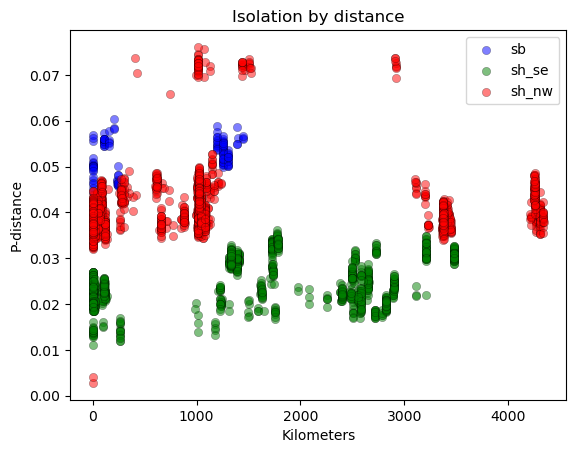

In [299]:
samples_with_geo_data = info_df.iloc[info_df['lat'].notnull().values]["sample_name"].values

for idx, color, label in [(sb_idx, "blue", "sb"),
                          (se_idx, "green", "sh_se"),
                          (nw_idx, "red", "sh_nw") ]:
    
    #subsample genetic and physical distance matricies
    g=gen_df.iloc[idx, idx]
    k=km_df.iloc[idx, idx]

    #remove duplicate values for plotting
    mask_upper = np.triu(np.ones(g.shape)).astype(bool)
    
    g.where(~mask_upper, np.nan, inplace=True)
    k.where(~mask_upper, np.nan, inplace=True)
   
    gs=g.values.flatten()
    ks=k.values.flatten()

    gs=gs[~np.isnan(gs)]
    ks=ks[~np.isnan(ks)]

    #plot scatter plot
    plt.scatter(ks, gs, alpha=0.5, color=color, edgecolors="black", linewidth=0.3, label=label)

    
plt.legend()
plt.title("Isolation by distance")
plt.xlabel("Kilometers")
plt.ylabel("P-distance")

# Display the figure
plt.savefig("p-dist_vs_geo-dist.png", dpi=600, bbox_inches='tight')
plt.savefig("p-dist_vs_geo-dist.svg", bbox_inches='tight')

plt.show()

### whats up with those super high ?

In [96]:
for col in g.columns:
    for idx in g.index:
        if g.at[idx, col] > 0.063:
            print(f"Column: {col}, Index: {idx}")


Column: Sh_NG_eb_6_2, Index: Sh_NG_kb_2_1
Column: Sh_NG_eb_6_2, Index: Sh_NG_kw_1_10
Column: Sh_NG_eb_6_2, Index: Sh_NG_os_1_4
Column: Sh_NG_eb_6_2, Index: sbo_cdivoire_raviart_108
Column: Sh_NG_eb_6_2, Index: sbo_cdivoire_raviart_109
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_154
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_155
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_160
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_162
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_163
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_164
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_170
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_171
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_172
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_175
Column: Sh_NG_eb_6_2, Index: sbo_niger_libore_176
Column: Sh_NG_eb_6_2, Index: sh_niger_SRR8284786
Column: Sh_NG_eb_6_2, Index: sh_niger_SRR8284787
Column: Sh_NG_eb_6_2, Index: sh_niger_SRR8284788
Column: Sh_NG_eb_6_2, Index: sh_niger_SRR8284789
Column: Sh_NG_eb_6_

In [ ]:
#they appear to be all from the Sh sample from nigeria with the highest Sb percentage

## Plot p-distance to a ref sample vs. lat and long

In [144]:
sh_samples = np.concatenate((sh_se_samples, sh_nw_samples))
countries=info_df.loc[info_df["sample_name"].isin(sh_samples), "country"].unique()
colors = cm.rainbow(np.linspace(0, 1, len(countries)))
country_colors = dict(zip(countries, colors))

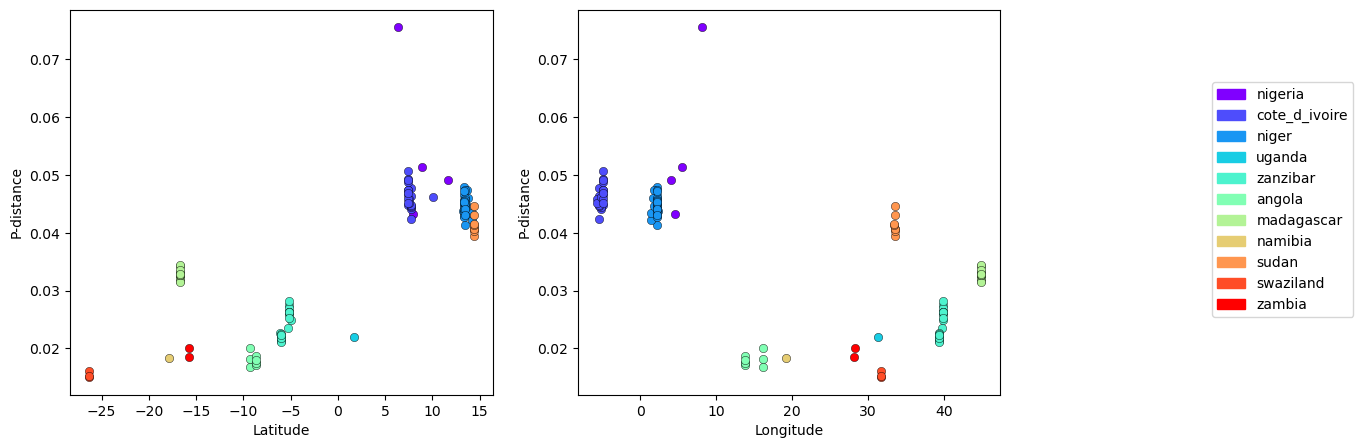

In [148]:
g = gen_df.iloc[sh_idx, sh_idx]
k = km_df.iloc[sh_idx, sh_idx]

ref_sample = "ssp_zambia_kafue_71"
ref_sample=info_df.iloc[info_df["lat"].astype(float).idxmin()]["sample_name"]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for Latitude
for sample, p_distance in g[ref_sample].items():
    if sample != ref_sample:
        country = info_df.loc[info_df["sample_name"] == sample, "country"].item()
        latitude = info_df.loc[info_df["sample_name"] == sample, "lat"].item()
        ax1.scatter(latitude, p_distance, color=country_colors[country], edgecolors="black", linewidth=0.3)
ax1.set_xlabel("Latitude")
ax1.set_ylabel("P-distance")

# Scatter plot for Longitude
for sample, p_distance in g[ref_sample].items():
    if sample != ref_sample:
        longitude = info_df.loc[info_df["sample_name"] == sample, "lon"].item()
        country = info_df.loc[info_df["sample_name"] == sample, "country"].item()
        ax2.scatter(longitude, p_distance, color=country_colors[country], edgecolors="black", linewidth=0.3)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("P-distance")

# Create a custom legend for the entire figure
legend_handles = [mpatches.Patch(color=country_colors[country], label=country) for country in countries]

# Positioning the legend can be done using bbox_to_anchor. 
# Here, I'm placing it outside the second subplot to the right.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.2, 0.5))


# Display the figure
plt.savefig("p-distance_lat_lon_gradient.png", dpi=600, bbox_inches='tight')
plt.savefig("p-distance_lat_lon_gradient.svg", bbox_inches='tight')


plt.show()


## Plot p-distance vs. geo distance and color for comparison

In [153]:
pop_map={sample: label for sample, label in zip(samples, labels)}

In [154]:
g=gen_df.iloc[sh_idx, sh_idx]
k=km_df.iloc[sh_idx, sh_idx]

In [158]:
#make a comps df
comps_df = pd.DataFrame(np.nan, index=g.index, columns=g.columns)
comps_df

# Classify comparisons
for row in comps_df.index:
    for col in comps_df.columns:
        if pop_map[row] == pop_map[col]:
            comps_df.at[row, col] = pop_map[row]
        else:
            comps_df.at[row, col] = 'nw_vs_se'

comps_df


,Sh_NG_eb_6_2,Sh_NG_kb_2_1,Sh_NG_kw_1_10,Sh_NG_os_1_4,sbo_cdivoire_raviart_108,sbo_cdivoire_raviart_109,sbo_niger_libore_154,sbo_niger_libore_155,sbo_niger_libore_160,sbo_niger_libore_162,...,sha_unguja_kinyasini_19,sha_unguja_kinyasini_23,sha_unguja_kinyasini_25,sha_unguja_kinyasini_26,sha_unguja_kinyasini_27,sha_unguja_kinyasini_28,sha_unguja_kinyasini_29,sha_unguja_kinyasini_30,sha_zambia_lishiko_66,ssp_zambia_kafue_71
Sh_NG_eb_6_2,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,...,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se
Sh_NG_kb_2_1,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,...,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se
Sh_NG_kw_1_10,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,...,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se
Sh_NG_os_1_4,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,...,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se
sbo_cdivoire_raviart_108,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,sh_nw,...,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sha_unguja_kinyasini_28,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,...,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se
sha_unguja_kinyasini_29,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,...,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se
sha_unguja_kinyasini_30,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,...,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se
sha_zambia_lishiko_66,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,nw_vs_se,...,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se,sh_se


In [159]:
color_mapping = {
    'sh_nw': 'red',
    'sh_se': 'green',
    'nw_vs_se': 'blue'
}

color_df = comps_df.replace(color_mapping)
color_df

,Sh_NG_eb_6_2,Sh_NG_kb_2_1,Sh_NG_kw_1_10,Sh_NG_os_1_4,sbo_cdivoire_raviart_108,sbo_cdivoire_raviart_109,sbo_niger_libore_154,sbo_niger_libore_155,sbo_niger_libore_160,sbo_niger_libore_162,...,sha_unguja_kinyasini_19,sha_unguja_kinyasini_23,sha_unguja_kinyasini_25,sha_unguja_kinyasini_26,sha_unguja_kinyasini_27,sha_unguja_kinyasini_28,sha_unguja_kinyasini_29,sha_unguja_kinyasini_30,sha_zambia_lishiko_66,ssp_zambia_kafue_71
Sh_NG_eb_6_2,red,red,red,red,red,red,red,red,red,red,...,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue
Sh_NG_kb_2_1,red,red,red,red,red,red,red,red,red,red,...,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue
Sh_NG_kw_1_10,red,red,red,red,red,red,red,red,red,red,...,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue
Sh_NG_os_1_4,red,red,red,red,red,red,red,red,red,red,...,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue
sbo_cdivoire_raviart_108,red,red,red,red,red,red,red,red,red,red,...,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sha_unguja_kinyasini_28,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue,...,green,green,green,green,green,green,green,green,green,green
sha_unguja_kinyasini_29,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue,...,green,green,green,green,green,green,green,green,green,green
sha_unguja_kinyasini_30,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue,...,green,green,green,green,green,green,green,green,green,green
sha_zambia_lishiko_66,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue,...,green,green,green,green,green,green,green,green,green,green


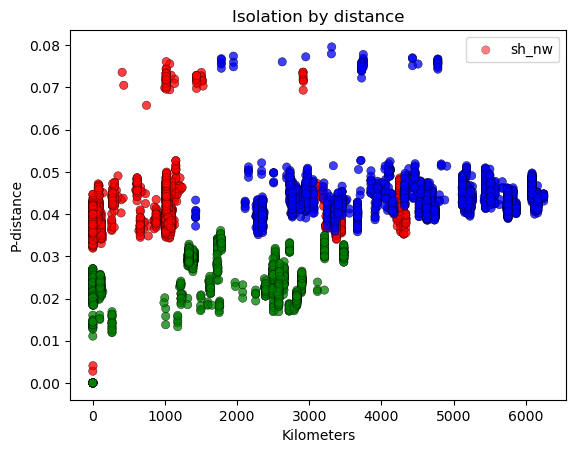

In [160]:
gs=g.values.flatten()
ks=k.values.flatten()
cs= color_df.values.flatten()

plt.scatter(ks, gs, alpha=0.5, color=cs, edgecolors="black", linewidth=0.3)
   
plt.legend()
plt.title("Isolation by distance")
plt.xlabel("Kilometers")
plt.ylabel("P-distance")
plt.show()

# ADM clines

In [176]:
samples=[]
with open("../admixture/samples.list", 'r') as f:
    samples = f.read().splitlines()

k=3
adm_df=pd.read_csv("../admixture/adm.{}.Q".format(k), sep=" ", header=None)
adm_df["sample_name"]=samples
adm_df.rename({0: "adm0", 1: "adm1", 2: "adm2"}, axis=1, inplace=True)
adm_df

cline_df = adm_df.merge(info_df[["sample_name", "country", "lat", "lon", "kmeans_label"]], how='left', on='sample_name')

cline_df = cline_df[cline_df["lat"].notnull()]
cline_df = cline_df[cline_df["lon"].notnull()]

cline_df = cline_df.loc[cline_df["kmeans_label"].isin(["sh_nw", "sh_se"])]

cline_df.reset_index(drop=True, inplace=True)

cline_df.to_csv("cline_adm{}.csv".format(k), sep=",", index=None)
cline_df

,adm0,adm1,adm2,sample_name,country,lat,lon,kmeans_label
0,0.035980,0.753328,0.210692,Sh_NG_eb_6_2,nigeria,6.328611,8.082222,sh_nw
1,0.015545,0.961096,0.023359,Sh_NG_kb_2_1,nigeria,11.710000,4.052222,sh_nw
2,0.022445,0.920098,0.057457,Sh_NG_kw_1_10,nigeria,8.892222,5.451389,sh_nw
3,0.055559,0.944431,0.000010,Sh_NG_os_1_4,nigeria,7.963889,4.563889,sh_nw
4,0.025241,0.959973,0.014786,sbo_cdivoire_raviart_108,cote_d_ivoire,7.400372,-4.896099,sh_nw
...,...,...,...,...,...,...,...,...
114,0.000010,0.999980,0.000010,ssp_niger_libore_166,niger,13.388050,2.199130,sh_nw
115,0.000010,0.999980,0.000010,ssp_niger_libore_167,niger,13.390080,2.197110,sh_nw
116,0.000010,0.999980,0.000010,ssp_niger_libore_168,niger,13.390080,2.197110,sh_nw
117,0.020853,0.979137,0.000010,ssp_niger_libore_169,niger,13.404170,2.188020,sh_nw


In [194]:
sh_cline_df = cline_df.loc[((cline_df["kmeans_label"] == "sh_nw") | (cline_df["kmeans_label"] == "sh_se"))].dropna(subset=['lat', 'lon'])
sh_samples = sh_cline_df["sample_name"]

kms = np.array([])
s1s = np.array([])
s2s = np.array([])

for s1 in sh_cline_df["sample_name"]:
    s1_lat=cline_df.loc[cline_df["sample_name"] == s1]["lat"].values[0]
    s1_lon=cline_df.loc[cline_df["sample_name"] == s1]["lon"].values[0]
    
    for s2 in sh_cline_df["sample_name"]:
        s2_lat=cline_df.loc[cline_df["sample_name"] == s2]["lat"].values[0]
        s2_lon=cline_df.loc[cline_df["sample_name"] == s2]["lon"].values[0]
        
        kms=np.append(kms, haversine((s1_lat, s1_lon), (s2_lat, s2_lon)))
        s1s=np.append(s1s, s1)
        s2s=np.append(s2s, s2)


In [26]:
km_df = pd.DataFrame([s1s, s2s, kms]).T
km_df.columns=["s1", "s2", "km"]
km_df.sort_values("km", ascending=False, axis=0).dropna().head()

,s1,s2,km
16843,ssp_cdivoire_noumousso_94,sha_madag_belesalampy_80,6250.452986
16842,ssp_cdivoire_noumousso_94,sha_madag_belesalampy_78,6250.452986
6786,sha_madag_belesalampy_76,ssp_cdivoire_noumousso_94,6250.452986
6288,sha_madag_belesalampy_73,ssp_cdivoire_noumousso_94,6250.452986
6952,sha_madag_belesalampy_77,ssp_cdivoire_noumousso_94,6250.452986


reps from two most distant sites
 - sha_madag_belesalampy_80
 - ssp_cdivoire_noumousso_94

In [27]:
sh_cline_df.loc[sh_cline_df["sample_name"] == "sha_madag_belesalampy_80"]

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label
77,0.569843,0.00001,0.430147,sha_madag_belesalampy_80,madagascar,na,human,-16.6646,44.84056,sh_se


In [28]:
sh_cline_df.loc[sh_cline_df["sample_name"] == "ssp_cdivoire_noumousso_94"]

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label
146,0.012478,0.00001,0.987512,ssp_cdivoire_noumousso_94,cote_d_ivoire,na,snail,10.107108,-5.142159,sh_nw


In [127]:
sh_cline_df.sort_values(by=["lat", "lon"], ascending=[False, False]).head(n=10)

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label,dist_from_ref
109,0.060901,0.00001,0.939089,sha_sudan_schoole_120,sudan,na,snail,14.386818,33.509815,sh_nw,4222.131919
111,0.099762,0.00001,0.900228,sha_sudan_schooli_129,sudan,na,snail,14.384994,33.445852,sh_nw,4215.23966
112,0.060267,0.00001,0.939723,sha_sudan_schooli_130,sudan,na,snail,14.384994,33.445852,sh_nw,4215.23966
110,0.137126,0.00001,0.862864,sha_sudan_schoolh_123,sudan,na,snail,14.373361,33.479290,sh_nw,4218.794875
105,0.098949,0.00001,0.901041,sha_sudan_canal4_125,sudan,na,snail,14.362360,33.487493,sh_nw,4219.636484
106,0.102089,0.00001,0.897901,sha_sudan_canal4_126,sudan,na,snail,14.362360,33.487493,sh_nw,4219.636484
107,0.056686,0.00001,0.943304,sha_sudan_canal4_127,sudan,na,snail,14.362360,33.487493,sh_nw,4219.636484
108,0.067311,0.00001,0.932679,sha_sudan_canal4_132,sudan,na,snail,14.362360,33.487493,sh_nw,4219.636484
46,0.013577,0.00001,0.986413,sh_niger_SRR8284786,niger,na,human,14.187521,1.486310,sh_nw,851.340532
47,0.000010,0.00001,0.999980,sh_niger_SRR8284787,niger,na,human,14.187521,1.486310,sh_nw,851.340532


In [128]:
sh_cline_df.sort_values(by=["lat", "lon"], ascending=[False, False]).tail(n=10)

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label,dist_from_ref
78,0.599515,0.00001,0.400475,sha_madag_belesalampy_81,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
79,0.577123,0.00001,0.422867,sha_madag_belesalampy_82,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
80,0.553578,0.00001,0.446412,sha_madag_belesalampy_83,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
81,0.617950,0.00001,0.382040,sha_madag_belesalampy_84,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
82,0.594832,0.00001,0.405158,sha_madag_belesalampy_87,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
83,0.999980,0.00001,0.000010,sha_namib_mayenzere_134,namibia,na,human,-17.858400,19.159700,sh_se,4097.645177
119,0.999980,0.00001,0.000010,sha_swaz_njojane_188,swaziland,na,unk,-26.277583,31.699567,sh_se,5675.511528
120,0.999980,0.00001,0.000010,sha_swaz_njojane_190,swaziland,na,unk,-26.277583,31.699567,sh_se,5675.511528
121,0.999980,0.00001,0.000010,sha_swaz_njojane_191,swaziland,na,unk,-26.277583,31.699567,sh_se,5675.511528
122,0.999980,0.00001,0.000010,sha_swaz_qomintaba_185,swaziland,na,unk,-27.138917,31.728250,sh_se,5740.324876


In [30]:
sh_niger_SRR8284786, sha_swaz_qomintaba_185

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label
109,0.060901,0.00001,0.939089,sha_sudan_schoole_120,sudan,na,snail,14.386818,33.509815,sh_nw
111,0.099762,0.00001,0.900228,sha_sudan_schooli_129,sudan,na,snail,14.384994,33.445852,sh_nw
112,0.060267,0.00001,0.939723,sha_sudan_schooli_130,sudan,na,snail,14.384994,33.445852,sh_nw
110,0.137126,0.00001,0.862864,sha_sudan_schoolh_123,sudan,na,snail,14.373361,33.479290,sh_nw
106,0.102089,0.00001,0.897901,sha_sudan_canal4_126,sudan,na,snail,14.362360,33.487493,sh_nw
...,...,...,...,...,...,...,...,...,...,...
83,0.999980,0.00001,0.000010,sha_namib_mayenzere_134,namibia,na,human,-17.858400,19.159700,sh_se
121,0.999980,0.00001,0.000010,sha_swaz_njojane_191,swaziland,na,unk,-26.277583,31.699567,sh_se
120,0.999980,0.00001,0.000010,sha_swaz_njojane_190,swaziland,na,unk,-26.277583,31.699567,sh_se
119,0.999980,0.00001,0.000010,sha_swaz_njojane_188,swaziland,na,unk,-26.277583,31.699567,sh_se


In [129]:
ref = "sh_niger_SRR8284786"

sh_cline_df["dist_from_ref"]="NA"

s1_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lat"].values[0]
s1_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lon"].values[0]

kms=[]

for index, row in tqdm(sh_cline_df.iterrows()):
    sample_id = row["sample_name"]
    s2_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lat"].values[0]
    s2_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lon"].values[0]

    km = haversine((s1_lat, s1_lon), (s2_lat, s2_lon))
    sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id, "dist_from_ref"] = km


sh_cline_df

121it [00:00, 1429.99it/s]


,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label,dist_from_ref
9,0.037610,0.221418,0.740972,Sh_NG_eb_6_2,nigeria,ebonyi,human,6.328611,8.082222,sh_nw,1132.961356
12,0.000010,0.015103,0.984887,Sh_NG_kb_2_1,nigeria,kebbi,human,11.710000,4.052222,sh_nw,391.404253
13,0.000010,0.055020,0.944970,Sh_NG_kw_1_10,nigeria,kwara,human,8.892222,5.451389,sh_nw,730.176092
14,0.018892,0.000010,0.981098,Sh_NG_os_1_4,nigeria,osun,human,7.963889,4.563889,sh_nw,769.141006
25,0.026561,0.012619,0.960820,sbo_cdivoire_raviart_108,cote_d_ivoire,na,snail,7.400372,-4.896099,sh_nw,1027.092362
...,...,...,...,...,...,...,...,...,...,...,...
161,0.011096,0.000010,0.988894,ssp_niger_libore_167,niger,na,snail,13.390080,2.197110,sh_nw,117.279903
162,0.009580,0.000010,0.990410,ssp_niger_libore_168,niger,na,snail,13.390080,2.197110,sh_nw,117.279903
163,0.012746,0.000010,0.987244,ssp_niger_libore_169,niger,na,snail,13.404170,2.188020,sh_nw,115.451739
164,0.000010,0.000010,0.999980,ssp_niger_libore_173,niger,na,snail,13.404170,2.188020,sh_nw,115.451739


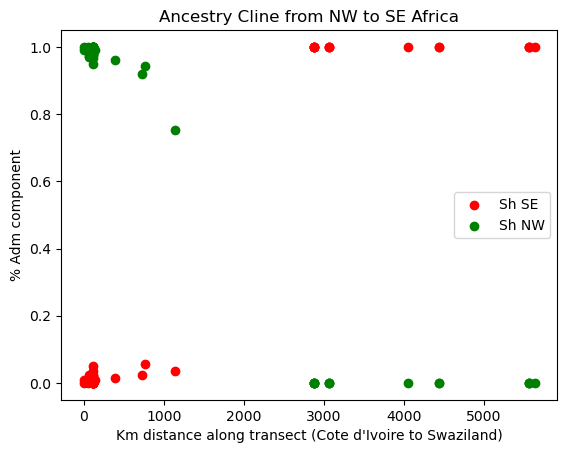

In [197]:
ref = "sh_niger_SRR8284786"

sh_cline_df["dist_from_ref"]="NA"

s1_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lat"].values[0]
s1_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lon"].values[0]

kms=[]

for index, row in sh_cline_df.iterrows():
    sample_id = row["sample_name"]
    s2_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lat"].values[0]
    s2_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lon"].values[0]

    km = haversine((s1_lat, s1_lon), (s2_lat, s2_lon))
    sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id, "dist_from_ref"] = km

    
tmp_df = sh_cline_df[sh_cline_df['country'].isin(["niger", "nigeria", "angola", "zambia", "namibia", "swaziland"])]
x=tmp_df["dist_from_ref"]
adm0_y=tmp_df["adm0"]
adm1_y=tmp_df["adm1"]
adm2_y=tmp_df["adm2"]

plt.scatter(x, adm0_y, c="red", label="Sh SE")
plt.scatter(x, adm1_y, c="green", label="Sh NW")
plt.xlabel("Km distance along transect (Cote d'Ivoire to Swaziland)")
plt.ylabel("% Adm component")
plt.title("Ancestry Cline from NW to SE Africa")
plt.legend()
plt.show()

tmp_df["sample_name"].to_csv("NW_SE_transect.samples", sep=",", index=None, header=None)

# Kriging map

In [177]:
min_lat = cline_df["lat"].min()
max_lat = cline_df["lat"].max()
min_lon = cline_df["lon"].min()
max_lon = cline_df["lon"].max()


min_lat = -35
max_lat = 20
min_lon = -15
max_lon = 55

In [178]:
cline_df

,adm0,adm1,adm2,sample_name,country,lat,lon,kmeans_label
0,0.035980,0.753328,0.210692,Sh_NG_eb_6_2,nigeria,6.328611,8.082222,sh_nw
1,0.015545,0.961096,0.023359,Sh_NG_kb_2_1,nigeria,11.710000,4.052222,sh_nw
2,0.022445,0.920098,0.057457,Sh_NG_kw_1_10,nigeria,8.892222,5.451389,sh_nw
3,0.055559,0.944431,0.000010,Sh_NG_os_1_4,nigeria,7.963889,4.563889,sh_nw
4,0.025241,0.959973,0.014786,sbo_cdivoire_raviart_108,cote_d_ivoire,7.400372,-4.896099,sh_nw
...,...,...,...,...,...,...,...,...
114,0.000010,0.999980,0.000010,ssp_niger_libore_166,niger,13.388050,2.199130,sh_nw
115,0.000010,0.999980,0.000010,ssp_niger_libore_167,niger,13.390080,2.197110,sh_nw
116,0.000010,0.999980,0.000010,ssp_niger_libore_168,niger,13.390080,2.197110,sh_nw
117,0.020853,0.979137,0.000010,ssp_niger_libore_169,niger,13.404170,2.188020,sh_nw


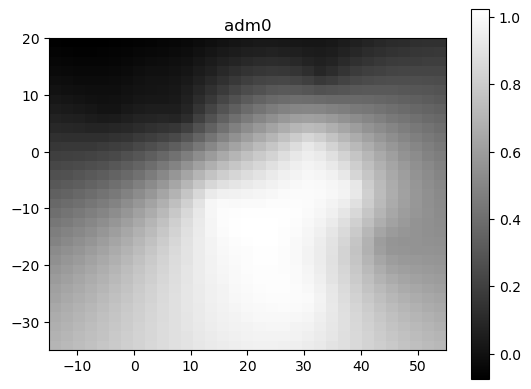

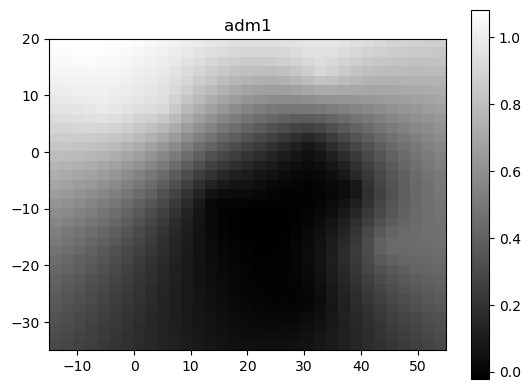

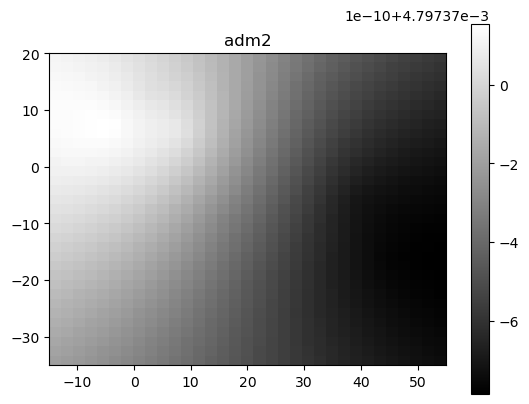

In [184]:
#from https://geostat-framework.readthedocs.io/_/downloads/pykrige/en/stable/pdf/

adm_cs={}
for adm_c in [0, 1, 2]:
    
    lon = cline_df["lon"]
    lat = cline_df["lat"]
    z = cline_df["adm{}".format(str(adm_c))]

    # Generate a regular grid with 60° longitude and 30° latitude steps:
    grid_lon = np.linspace(min_lon, max_lon, 33)
    grid_lat = np.linspace(min_lat, max_lat, 33)
    # Create ordinary kriging object:

    OK = OrdinaryKriging(
        lon,
        lat,
        z,
        variogram_model="linear",
        verbose=False,
        enable_plotting=False,
        coordinates_type="geographic",
        )

    # Execute on grid:
    adm_cs[adm_c], ss1 = OK.execute("grid", grid_lon, grid_lat)

    plt.imshow(adm_cs[adm_c], extent=[min_lon, max_lon
                                      , min_lat, max_lat], cmap='gray', origin="lower")
    plt.colorbar()
    plt.title("adm{}".format(str(adm_c)))
    plt.show()


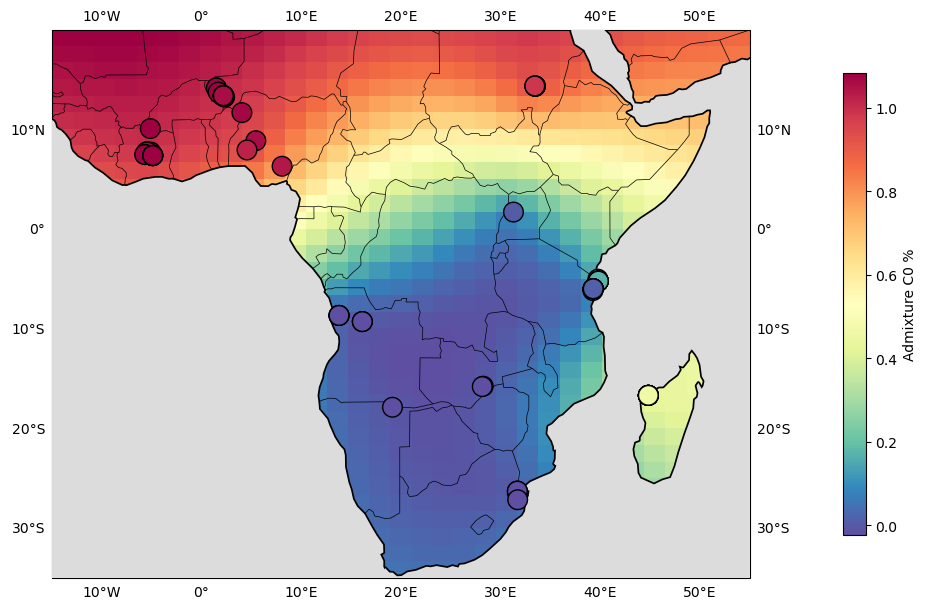

In [185]:
figure(figsize=(12, 12))

ax = plt.axes(projection=ccrs.PlateCarree())


plt.scatter(cline_df["lon"], cline_df["lat"],
         c=-cline_df["adm0"], cmap='Spectral_r', marker='o', s = 200, linewidth=1, edgecolor="black",
         transform=ccrs.Geodetic(), alpha=1, zorder=10
         )

plt.imshow(adm_cs[1], extent=(min_lon, max_lon, min_lat, max_lat), cmap='Spectral_r', origin="lower", zorder=1)
plt.colorbar(shrink=0.5, pad=0.1, label="Admixture C0 %")

ax.add_feature(cf.OCEAN, facecolor='gainsboro', zorder=4)

ax.coastlines(zorder=2, linewidth=2.5)
ax.add_feature(cf.BORDERS, edgecolor='black', zorder=4, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=5, color="white", alpha=0)


plt.xlim([-15, 55])
plt.ylim([-35, 20])

# Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('kigring_map.png', dpi=300)
plt.savefig('kigring_map.svg')


plt.show()

# Clines Sb. alleles masked

## Prep VCF file

- LD filter
- Autosomes

In [ ]:
#convert phased vcf to unphase vcf

#get rid of "|" for "/"
sed '/^##/! s/|/\//g' ../stats_minus_introgressed_alleles/high_freq_sh.vcf >slashes.vcf


#convert half missing to missing
sed -e '/^#/!s/[01]\/\./\.\/./g' -e '/^#/!s/\.\/[01]/\.\/\./g' slashes.vcf >full_missing.vcf


#rearrange 1/0 to 0/1
sed '/^#/!s/1\/0/0\/1/g' full_missing.vcf >minus_sb_unphased.vcf


In [267]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf minus_sb_unphased.vcf \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \
        --keep samples.list \
        --recode \
        --recode-INFO-all \
        --out minus_sb_unphased_autosomes


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf minus_sb_unphased.vcf
	--chr NC_067196.1
	--chr NC_067197.1
	--chr NC_067198.1
	--chr NC_067199.1
	--chr NC_067200.1
	--chr NC_067201.1
	--chr NC_067202.1
	--keep samples.list
	--recode-INFO-all
	--max-missing 0.15
	--out minus_sb_unphased_autosomes
	--recode

Keeping individuals in 'keep' list
After filtering, kept 119 out of 141 Individuals
Outputting VCF file...
After filtering, kept 25882300 out of a possible 25882300 Sites
Run Time = 1413.00 seconds


In [272]:
miss_df=pd.read_csv("minus_sb_unphased_autosomes.lmiss", sep="\t")
miss_df

,CHR,POS,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS
0,NC_067196.1,2199875,238,0,64,0.268908
1,NC_067196.1,2199882,238,0,64,0.268908
2,NC_067196.1,2199889,238,0,64,0.268908
3,NC_067196.1,2199896,238,0,64,0.268908
4,NC_067196.1,2199897,238,0,64,0.268908
...,...,...,...,...,...,...
25882295,NC_067202.1,19478785,238,0,2,0.008403
25882296,NC_067202.1,19478806,238,0,2,0.008403
25882297,NC_067202.1,19478807,238,0,2,0.008403
25882298,NC_067202.1,19478810,238,0,2,0.008403


In [276]:
miss_df.loc[miss_df["F_MISS"] < 0.15, ["CHR", "POS"]].to_csv("minus_sb_unphased_autosomes_keep.tsv", header=False, index=False, sep="\t")

In [280]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf minus_sb_unphased_autosomes.recode.vcf \
        --positions minus_sb_unphased_autosomes_keep.tsv \
        --recode \
        --recode-INFO-all \
        --out minus_sb_unphased_autosomes_high_gt


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf minus_sb_unphased_autosomes.recode.vcf
	--recode-INFO-all
	--out minus_sb_unphased_autosomes_high_gt
	--positions minus_sb_unphased_autosomes_keep.tsv
	--recode

After filtering, kept 119 out of 119 Individuals
Outputting VCF file...
After filtering, kept 23464352 out of a possible 25882300 Sites
Run Time = 1116.00 seconds


In [281]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    plink \
        --vcf minus_sb_unphased_autosomes_high_gt.recode.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out minus_sb_unphased_autosomes_high_gt_ld

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to minus_sb_unphased_autosomes_high_gt_ld.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out minus_sb_unphased_autosomes_high_gt_ld
  --vcf minus_sb_unphased_autosomes_high_gt.recode.vcf

1031287 MB RAM detected; reserving 515643 MB for main workspace.
--vcf: minus_sb_unphased_autosomes_high_gt_ld-temporary.bed +
minus_sb_unphased_autosomes_high_gt_ld-temporary.bim +
minus_sb_unphased_autosomes_high_gt_ld-temporary.fam written.
23464352 variants loaded from .bim file.
119 people (0 males, 0 females, 119 ambiguous) loaded from .fam.
Ambiguous sex IDs written to minus_sb_unphased_autosomes_high_gt_ld.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 119 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171

In [282]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf minus_sb_unphased_autosomes_high_gt.recode.vcf \
        --exclude minus_sb_unphased_autosomes_high_gt_ld.prune.out \
        --recode \
        --recode-INFO-all \
        --out minus_sb_unphased_autosomes_high_gt_ld


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf minus_sb_unphased_autosomes_high_gt.recode.vcf
	--recode-INFO-all
	--out minus_sb_unphased_autosomes_high_gt_ld
	--recode
	--exclude minus_sb_unphased_autosomes_high_gt_ld.prune.out

After filtering, kept 119 out of 119 Individuals
Outputting VCF file...
After filtering, kept 2450915 out of a possible 23464352 Sites
Run Time = 169.00 seconds


In [283]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf minus_sb_unphased_autosomes_high_gt_ld.recode.vcf \
        --thin 10000 \
        --recode \
        --recode-INFO-all \
        --out minus_sb_mantel


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf minus_sb_unphased_autosomes_high_gt_ld.recode.vcf
	--recode-INFO-all
	--thin 10000
	--out minus_sb_mantel
	--recode

After filtering, kept 119 out of 119 Individuals
Outputting VCF file...
After filtering, kept 23231 out of a possible 2450915 Sites
Run Time = 9.00 seconds


## Calculate genetic distances 
calculated wtih `VCF2Dis` from https://github.com/BGI-shenzhen/VCF2Dis.  Cloned into `sch_hae_scan/bin`

In [284]:
#get the genetic data
vcf_reader = vcf.Reader(open('minus_sb_mantel.recode.vcf', 'r'))
#get the sample order
samples=vcf_reader.samples

In [285]:
%%bash

~/sch_hae_scan/bin/VCF2Dis/bin/VCF2Dis -InPut minus_sb_mantel.recode.vcf -OutPut minus_sb_mantel_p_distance.tsv

Total Sample Number to construct p-distance matrix is [ 119 ]
Start To Cal ...
Start To Create P_distance ...
P_distance is created done ...


In [286]:
#read in distance matrix
gen_df = pd.read_table("minus_sb_mantel_p_distance.tsv", sep="\t", header=None, index_col=0, skiprows=[0])

#VCF2Dis only keeps the first 20 chars in the sample name... so need to re-header
gen_df.index=samples
gen_df.columns=samples
gen_df.to_csv("minus_sb_mantel_p_distance.csv", sep=",")
gen_df

,Sh_NG_eb_6_2,Sh_NG_kb_2_1,Sh_NG_kw_1_10,Sh_NG_os_1_4,sbo_cdivoire_raviart_108,sbo_cdivoire_raviart_109,sbo_niger_libore_154,sbo_niger_libore_155,sbo_niger_libore_160,sbo_niger_libore_162,...,ssp_cdivoire_raviart_99,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_zambia_kafue_71
Sh_NG_eb_6_2,0.000000,0.057790,0.065890,0.059385,0.061316,0.063249,0.059804,0.063373,0.061564,0.060453,...,0.063292,0.061883,0.059803,0.063636,0.061446,0.064538,0.066004,0.061077,0.061112,0.069467
Sh_NG_kb_2_1,0.057790,0.000000,0.051172,0.041551,0.045190,0.047634,0.042330,0.045042,0.043200,0.043269,...,0.047575,0.045057,0.044455,0.043918,0.045411,0.043517,0.047844,0.043403,0.045775,0.054115
Sh_NG_kw_1_10,0.065890,0.051172,0.000000,0.051641,0.052376,0.054358,0.052389,0.054496,0.053299,0.052085,...,0.057363,0.051202,0.053659,0.053885,0.053643,0.054131,0.057191,0.052437,0.054222,0.064155
Sh_NG_os_1_4,0.059385,0.041551,0.051641,0.000000,0.042914,0.043591,0.041588,0.043344,0.042137,0.041977,...,0.046527,0.041628,0.045280,0.040314,0.042386,0.041037,0.045264,0.042046,0.042606,0.051323
sbo_cdivoire_raviart_108,0.061316,0.045190,0.052376,0.042914,0.000000,0.039350,0.043419,0.045023,0.043974,0.044156,...,0.042389,0.044246,0.046867,0.045418,0.045850,0.045726,0.046801,0.043411,0.044231,0.055180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_166,0.064538,0.043517,0.054131,0.041037,0.045726,0.046555,0.044025,0.045073,0.044414,0.042843,...,0.049268,0.044348,0.045740,0.043605,0.045086,0.000000,0.046156,0.042587,0.046288,0.057796
ssp_niger_libore_167,0.066004,0.047844,0.057191,0.045264,0.046801,0.047906,0.045781,0.047538,0.046332,0.046753,...,0.050812,0.046700,0.047317,0.046514,0.048546,0.046156,0.000000,0.045699,0.049176,0.058533
ssp_niger_libore_168,0.061077,0.043403,0.052437,0.042046,0.043411,0.044454,0.041702,0.043365,0.041448,0.042684,...,0.047124,0.042677,0.043105,0.043499,0.044500,0.042587,0.045699,0.000000,0.043773,0.055251
ssp_niger_libore_169,0.061112,0.045775,0.054222,0.042606,0.044231,0.046247,0.043336,0.045008,0.043436,0.043232,...,0.050045,0.041257,0.046091,0.045336,0.045353,0.046288,0.049176,0.043773,0.000000,0.055223


## Get geo distances

In [287]:
km_dists=np.array([])
for s1 in samples:
    s1_lat=info_df.loc[info_df["sample_name"] == s1]["lat"].values[0]
    s1_lon=info_df.loc[info_df["sample_name"] == s1]["lon"].values[0]
    
    for s2 in samples:
        s2_lat=info_df.loc[info_df["sample_name"] == s2]["lat"].values[0]
        s2_lon=info_df.loc[info_df["sample_name"] == s2]["lon"].values[0]
        
        km_dists=np.append(km_dists, haversine((s1_lat, s1_lon), (s2_lat, s2_lon)))
        
#reshape into a 2d matrix
km_dists.shape=(len(samples), len(samples))

#convert to a df
km_df=pd.DataFrame(data=km_dists, columns=samples, index=samples)
km_df.to_csv("mantel_geo_distance.csv", sep=",")
km_df

,Sh_NG_eb_6_2,Sh_NG_kb_2_1,Sh_NG_kw_1_10,Sh_NG_os_1_4,sbo_cdivoire_raviart_108,sbo_cdivoire_raviart_109,sbo_niger_libore_154,sbo_niger_libore_155,sbo_niger_libore_160,sbo_niger_libore_162,...,ssp_cdivoire_raviart_99,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_zambia_kafue_71
Sh_NG_eb_6_2,0.000000,744.163648,406.596665,428.646631,1437.662735,1437.662735,1015.693312,1015.693312,1015.379965,1015.379965,...,1437.662735,1015.379965,1015.379965,1015.379965,1015.693312,1015.379965,1015.693312,1015.693312,1017.525832,3307.364012
Sh_NG_kb_2_1,744.163648,0.000000,348.708159,420.302849,1091.722252,1091.722252,274.661645,274.661645,274.347997,274.347997,...,1091.722252,274.347997,274.347997,274.347997,274.661645,274.347997,274.661645,274.661645,276.446754,4048.580063
Sh_NG_kw_1_10,406.596665,348.708159,0.000000,142.074057,1150.931885,1150.931885,613.286014,613.286014,612.975199,612.975199,...,1150.931885,612.975199,612.975199,612.975199,613.286014,612.975199,613.286014,613.286014,615.132118,3713.261306
Sh_NG_os_1_4,428.646631,420.302849,142.074057,0.000000,1044.319112,1044.319112,656.412821,656.412821,656.118828,656.118828,...,1044.319112,656.118828,656.118828,656.118828,656.412821,656.118828,656.412821,656.412821,658.241419,3705.611170
sbo_cdivoire_raviart_108,1437.662735,1091.722252,1150.931885,1044.319112,0.000000,0.000000,1022.156004,1022.156004,1022.178587,1022.178587,...,0.000000,1022.178587,1022.178587,1022.178587,1022.156004,1022.178587,1022.156004,1022.156004,1022.410121,4461.414824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_166,1015.379965,274.347997,612.975199,656.118828,1022.178587,1022.178587,0.314163,0.314163,0.000000,0.000000,...,1022.178587,0.000000,0.000000,0.000000,0.314163,0.000000,0.314163,0.314163,2.158047,4321.752445
ssp_niger_libore_167,1015.693312,274.661645,613.286014,656.412821,1022.156004,1022.156004,0.000000,0.000000,0.314163,0.314163,...,1022.156004,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,4322.066439
ssp_niger_libore_168,1015.693312,274.661645,613.286014,656.412821,1022.156004,1022.156004,0.000000,0.000000,0.314163,0.314163,...,1022.156004,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,4322.066439
ssp_niger_libore_169,1017.525832,276.446754,615.132118,658.241419,1022.410121,1022.410121,1.849721,1.849721,2.158047,2.158047,...,1022.410121,2.158047,2.158047,2.158047,1.849721,2.158047,1.849721,1.849721,0.000000,4323.887609


## Mantel Tests

In [288]:
# Need to do 4 comparisons
# Sb
# Sh
# NW
# SE

#get idecies of each sample type/species of interest

labels = []

for sample in samples:
    labels.append(pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0])
    
sb_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sb"]
nw_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sh_nw"]
se_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sh_se"]
sh_idx=nw_idx + se_idx


In [289]:
for idx, color, label in [(se_idx, "green", "sh_se"),
                          (nw_idx, "red", "sh_nw") ]:
    
    #subsample genetic and physical distance matricies
    g=gen_df.iloc[idx, idx]
    k=km_df.iloc[idx, idx]

    #conduct the mantel test
    r2, p, n = mantel(g, k, permutations=1000)
    print("Mantel test - {}: r2={:.2f}, p={:.3f}, n={}".format(label, r2, p, n))

Mantel test - sh_se: r2=0.17, p=0.030, n=50
Mantel test - sh_nw: r2=0.24, p=0.029, n=69


## Plot d-distance vs geo-distance

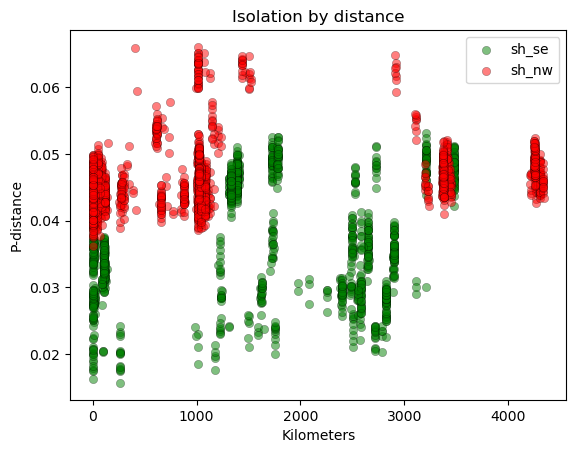

In [290]:
samples_with_geo_data = info_df.iloc[info_df['lat'].notnull().values]["sample_name"].values

for idx, color, label in [(se_idx, "green", "sh_se"),
                          (nw_idx, "red", "sh_nw") ]:
    
    #subsample genetic and physical distance matricies
    g=gen_df.iloc[idx, idx]
    k=km_df.iloc[idx, idx]

    #remove duplicate values for plotting
    mask_upper = np.triu(np.ones(g.shape)).astype(bool)
    
    g.where(~mask_upper, np.nan, inplace=True)
    k.where(~mask_upper, np.nan, inplace=True)
   
    gs=g.values.flatten()
    ks=k.values.flatten()

    gs=gs[~np.isnan(gs)]
    ks=ks[~np.isnan(ks)]

    #plot scatter plot
    plt.scatter(ks, gs, alpha=0.5, color=color, edgecolors="black", linewidth=0.3, label=label)

    
plt.legend()
plt.title("Isolation by distance")
plt.xlabel("Kilometers")
plt.ylabel("P-distance")

# Display the figure
plt.savefig("minus_sb_p-dist_vs_geo-dist.png", dpi=600, bbox_inches='tight')
plt.savefig("minus_sb_p-dist_vs_geo-dist.svg", bbox_inches='tight')


plt.show()

## Plot p-distance to a ref sample vs. lat and long

In [291]:
sh_samples = np.concatenate((sh_se_samples, sh_nw_samples))
countries=info_df.loc[info_df["sample_name"].isin(sh_samples), "country"].unique()
colors = cm.rainbow(np.linspace(0, 1, len(countries)))
country_colors = dict(zip(countries, colors))

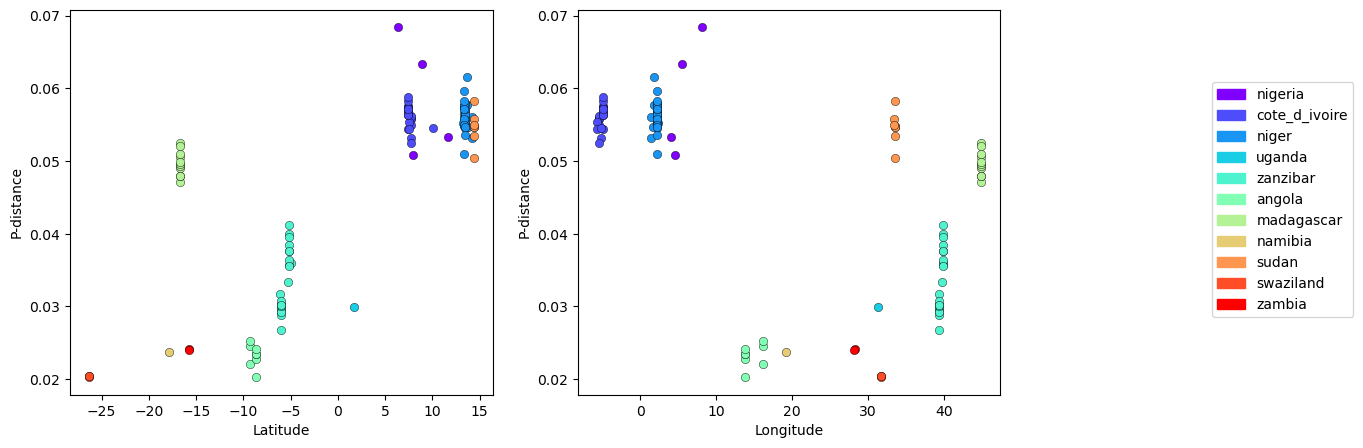

In [292]:
g = gen_df.iloc[sh_idx, sh_idx]
k = km_df.iloc[sh_idx, sh_idx]

ref_sample = "ssp_zambia_kafue_71"
ref_sample=info_df.iloc[info_df["lat"].astype(float).idxmin()]["sample_name"]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for Latitude
for sample, p_distance in g[ref_sample].items():
    if sample != ref_sample:
        country = info_df.loc[info_df["sample_name"] == sample, "country"].item()
        latitude = info_df.loc[info_df["sample_name"] == sample, "lat"].item()
        ax1.scatter(latitude, p_distance, color=country_colors[country], edgecolors="black", linewidth=0.3)
ax1.set_xlabel("Latitude")
ax1.set_ylabel("P-distance")

# Scatter plot for Longitude
for sample, p_distance in g[ref_sample].items():
    if sample != ref_sample:
        longitude = info_df.loc[info_df["sample_name"] == sample, "lon"].item()
        country = info_df.loc[info_df["sample_name"] == sample, "country"].item()
        ax2.scatter(longitude, p_distance, color=country_colors[country], edgecolors="black", linewidth=0.3)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("P-distance")

# Create a custom legend for the entire figure
legend_handles = [mpatches.Patch(color=country_colors[country], label=country) for country in countries]

# Positioning the legend can be done using bbox_to_anchor. 
# Here, I'm placing it outside the second subplot to the right.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.2, 0.5))


# Display the figure
plt.savefig("minus_sb_p-distance_lat_lon_gradient.png", dpi=600, bbox_inches='tight')
plt.savefig("minus_sb_p-distance_lat_lon_gradient.svg", bbox_inches='tight')


plt.show()


# mask sb alleles (w/VCFTOOLS)

In [19]:
Path("{}/masked_clines".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/masked_clines".format(results_dir))

## Read in the rfmix data and get an autosomal vcf file of only the query SH samples from rfmix run

In [45]:
#read in rfmix table
rf_df=pd.read_csv(f"{results_dir}/rfmix/rfmix_df.csv")
rf_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,NC_067196.1,212192,289797,0.74,1.01,860,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,NC_067196.1,289797,302958,1.01,1.06,645,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1


In [46]:
rf_samples = rf_df.columns[6:]
rf_samples = list(set([s[:-2] if s.endswith('.0') or s.endswith('.1') else s for s in rf_samples]))

In [79]:
len(rf_samples)

111

In [57]:
if os.path.exists("sh_se.samples.list"):
    os.remove("sh_se.samples.list")
    
if os.path.exists("sh_nw.samples.list"):
    os.remove("sh_nw.samples.list")


for sample in rf_samples:
    try:
        pop = info_df.dropna(axis=0, subset=["lat", "lon"]).loc[info_df["sample_name"] == sample, "kmeans_label" ].values[0]
        with open(f"{pop}.samples.list", 'a') as f:
            f.write(f"{sample}\n")
            
    except:
        next

In [80]:
!cat sh_se.samples.list sh_nw.samples.list >sh.samples.list

In [58]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf  ~/sch_hae_scan/results/filter_genotypes/sorted_annotated_snps.vcf \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \
        --keep sh.samples.list \
        --recode \
        --recode-INFO-all \
        --out sh_rf_autosomes


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf /master/nplatt/sch_hae_scan/results/filter_genotypes/sorted_annotated_snps.vcf
	--chr NC_067196.1
	--chr NC_067197.1
	--chr NC_067198.1
	--chr NC_067199.1
	--chr NC_067200.1
	--chr NC_067201.1
	--chr NC_067202.1
	--keep sh.samples.list
	--recode-INFO-all
	--out sh_rf_autosomes
	--recode

Keeping individuals in 'keep' list
After filtering, kept 89 out of 171 Individuals
Outputting VCF file...
After filtering, kept 30337899 out of a possible 38198427 Sites
Run Time = 7664.00 seconds


In [ ]:
%%bash

conda run -n scan-clines --cwd . --live-stream bgzip sh_rf_autosomes.recode.vcf
conda run -n scan-clines --cwd . --live-stream tabix -p vcf sh_rf_autosomes.recode.vcf.gz

In [ ]:
%%bash

cat sh.samples.list | parallel -j 48 "conda run -n scan-clines --cwd . --live-stream bcftools view -s {} sh_rf_autosomes.recode.vcf.gz -o {}.vcf"

## Now find all the locations of Sb alleles in each sample and create a bed file for masking

In [74]:
se_samples = np.loadtxt("sh_se.samples.list", dtype=str)
nw_samples = np.loadtxt("sh_nw.samples.list", dtype=str)

sh_samples = np.concatenate((se_samples, nw_samples))

sh_haplotypes = [sample + suffix for sample in sh_samples for suffix in [".0", ".1"]]


#intersection_cols = list(set(rf_df.columns) & set(sh_haplotypes))

# Combine the individual strings and the list from the intersection
cols_to_use = ["chrom", "s_pos", "e_pos", "n_snps"] + sh_haplotypes


In [75]:
to_mask_df=rf_df[cols_to_use]
to_mask_df["samples"]=None
to_mask_df

/tmp/ipykernel_238243/3350337365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_mask_df["samples"]=None


,chrom,s_pos,e_pos,n_snps,sha_madag_belesalampy_81.0,sha_madag_belesalampy_81.1,sha_swaz_njojane_191.0,sha_swaz_njojane_191.1,sha_madag_belesalampy_80.0,sha_madag_belesalampy_80.1,...,sbo_cdivoire_raviart_109.1,ssp_cdivoire_raviart_111.0,ssp_cdivoire_raviart_111.1,ssp_niger_libore_156.0,ssp_niger_libore_156.1,sh_niger_SRR8284789.0,sh_niger_SRR8284789.1,ssp_cdivoire_raviart_99.0,ssp_cdivoire_raviart_99.1,samples
0,NC_067196.1,124225,212192,1302,1,1,1,1,1,1,...,1,1,1,0,0,0,0,1,1,None
1,NC_067196.1,212192,289797,860,1,1,1,1,1,1,...,1,1,1,0,0,0,0,1,1,None
2,NC_067196.1,289797,302958,645,1,1,1,1,1,1,...,1,1,1,0,0,0,0,1,1,None
3,NC_067196.1,302958,623463,2980,1,1,1,1,1,1,...,1,1,1,0,0,0,0,1,1,None
4,NC_067196.1,623463,625997,25,1,1,1,1,1,1,...,1,1,1,0,0,0,0,1,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,365,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,None
39473,NC_067199.1,46761155,46761224,15,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,None
39474,NC_067199.1,46761224,46762583,115,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,None
39475,NC_067199.1,46762583,46763230,75,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,None


In [76]:
mask_samples = list(to_mask_df.columns[4:-1])
mask_samples = [s[:-2] if s.endswith('.1') or s.endswith('.0') else s for s in mask_samples]
mask_samples = list(set(mask_samples))
mask_samples

['sha_niger_libore_138',
 'ssp_cdivoire_kongobo_98',
 'ssp_niger_libore_165',
 'sh_niger_SRR8284790',
 'sha_sudan_canal4_125',
 'sbo_niger_libore_172',
 'Sh_NG_eb_6_2',
 'sha_niger_libore_142',
 'ssp_cdivoire_raviart_91',
 'Sh_NG_os_1_4',
 'sha_madag_belesalampy_81',
 'sha_swaz_njojane_191',
 'sha_madag_belesalampy_80',
 'sha_unguja_kinyasini_16',
 'sha_niger_libore_143',
 'sbo_niger_libore_155',
 'sbo_cdivoire_raviart_108',
 'sha_niger_libore_139',
 'sha_madag_belesalampy_75',
 'ssp_cdivoire_linguebo_100',
 'ssp_niger_libore_168',
 'ssp_niger_libore_169',
 'ssp_zambia_kafue_71',
 'sbo_niger_libore_163',
 'sha_sudan_schoolh_123',
 'ssp_cdivoire_kongobo_97',
 'ssp_cdivoire_raviart_114',
 'sha_niger_libore_141',
 'sh_niger_SRR8284788',
 'sha_niger_libore_149',
 'ssp_cdivoire_raviart_110',
 'sha_madag_belesalampy_83',
 'sbo_uganda_runga_44',
 'sh_niger_SRR8284787',
 'ssp_niger_libore_167',
 'sha_niger_libore_150',
 'ssp_cdivoire_raviart_89',
 'ssp_niger_libore_159',
 'sha_angola_cota_57',

In [77]:
len(mask_samples)

89

In [78]:
sb_allele = 0

for sample in mask_samples:
    sample_to_mask_bed = to_mask_df.loc[((to_mask_df[f"{sample}.0"] == sb_allele) | (to_mask_df[f"{sample}.1"] == sb_allele)), ["chrom", "s_pos", "e_pos"]]
    sample_to_mask_bed["s_pos"] = sample_to_mask_bed["s_pos"]-1
    sample_to_mask_bed["e_pos"] = sample_to_mask_bed["e_pos"]+1
    sample_to_mask_bed.to_csv(f"{sample}.mask.bed", sep="\t", header=False, index=False)

## Mask each sample and then merge into a single masked.vcf

In [ ]:
%%bash
cat sh.samples.list | parallel -j 48 "conda run -n scan-clines --cwd . --live-stream vcftools --vcf {}.vcf --exclude-bed {}.mask.bed --recode --recode-INFO-all --out {}.masked"

In [ ]:
cat sh.samples.list | parallel -j 48 "conda run -n scan-clines --cwd . --live-stream bgzip {}.masked.recode.vcf"
cat sh.samples.list | parallel -j 48 "conda run -n scan-clines --cwd . --live-stream tabix -p vcf {}.masked.recode.vcf.gz"
ls *.masked.recode.vcf.gz >masked.list

In [ ]:
#https://samtools.github.io/bcftools/bcftools.html#merge
bcftools --merge snps --file-list masked.list --output masked.vcf --output-type v

## Filter and prep the masked vcf for downstream analyses

In [ ]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools --missing-site --vcf masked.vcf

In [81]:
miss_df=pd.read_csv("out.lmiss", sep="\t", header=0)

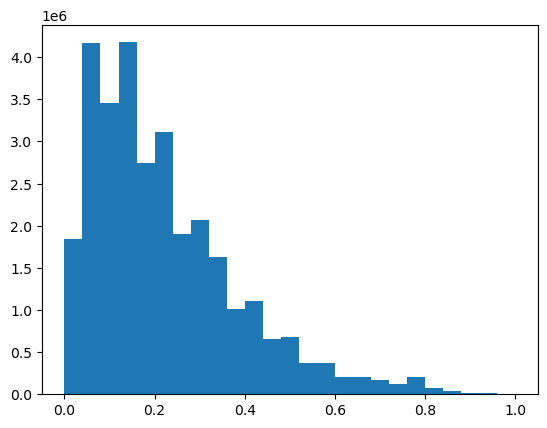

In [86]:
plt.hist(miss_df["F_MISS"], bins=25)
plt.show()

In [92]:
(miss_df["F_MISS"]<0.1).sum()

0.23642863337372175

In [93]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
    --max-missing 0.9 \
    --vcf masked.vcf \
    --recode \
    --recode-INFO-all \
    --out max_miss_masked


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf masked.vcf
	--recode-INFO-all
	--max-missing 0.9
	--out max_miss_masked
	--recode

After filtering, kept 89 out of 89 Individuals
Outputting VCF file...
After filtering, kept 7172748 out of a possible 30337899 Sites
Run Time = 1966.00 seconds


In [94]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    plink \
        --vcf max_miss_masked.recode.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out max_miss_masked_ld

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to max_miss_masked_ld.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out max_miss_masked_ld
  --vcf max_miss_masked.recode.vcf

1031287 MB RAM detected; reserving 515643 MB for main workspace.
--vcf: max_miss_masked_ld-temporary.bed + max_miss_masked_ld-temporary.bim +
max_miss_masked_ld-temporary.fam written.
7172748 variants loaded from .bim file.
89 people (0 males, 0 females, 89 ambiguous) loaded from .fam.
Ambiguous sex IDs written to max_miss_masked_ld.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 89 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899

In [95]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf max_miss_masked.recode.vcf \
        --exclude max_miss_masked_ld.prune.out \
        --recode \
        --recode-INFO-all \
        --out max_miss_masked_ld


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf max_miss_masked.recode.vcf
	--recode-INFO-all
	--out max_miss_masked_ld
	--recode
	--exclude max_miss_masked_ld.prune.out

After filtering, kept 89 out of 89 Individuals
Outputting VCF file...
After filtering, kept 577561 out of a possible 7172748 Sites
Run Time = 146.00 seconds


In [98]:
%%bash

conda run -n scan-clines --cwd . --live-stream \
    vcftools \
        --vcf max_miss_masked_ld.recode.vcf \
        --thin 10000 \
        --recode \
        --recode-INFO-all \
        --out minus_sb_mantel


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf max_miss_masked_ld.recode.vcf
	--recode-INFO-all
	--thin 10000
	--out minus_sb_mantel
	--recode

After filtering, kept 89 out of 89 Individuals
Outputting VCF file...
After filtering, kept 13519 out of a possible 577561 Sites
Run Time = 5.00 seconds


## Calculate genetic distances 
calculated wtih `VCF2Dis` from https://github.com/BGI-shenzhen/VCF2Dis.  Cloned into `sch_hae_scan/bin`

In [99]:
#get the genetic data
vcf_reader = vcf.Reader(open('minus_sb_mantel.recode.vcf', 'r'))
#get the sample order
samples=vcf_reader.samples

In [100]:
%%bash

~/sch_hae_scan/bin/VCF2Dis/bin/VCF2Dis -InPut minus_sb_mantel.recode.vcf -OutPut minus_sb_mantel_p_distance.tsv

Total Sample Number to construct p-distance matrix is [ 89 ]
Start To Cal ...
Start To Create P_distance ...
P_distance is created done ...


In [101]:
#read in distance matrix
gen_df = pd.read_table("minus_sb_mantel_p_distance.tsv", sep="\t", header=None, index_col=0, skiprows=[0])

#VCF2Dis only keeps the first 20 chars in the sample name... so need to re-header
gen_df.index=samples
gen_df.columns=samples
gen_df.to_csv("minus_sb_mantel_p_distance.csv", sep=",")
gen_df

,sbo_cdivoire_raviart_108,sbo_cdivoire_raviart_109,sbo_niger_libore_154,sbo_niger_libore_155,sbo_niger_libore_160,sbo_niger_libore_162,sbo_niger_libore_163,sbo_niger_libore_164,sbo_niger_libore_170,sbo_niger_libore_171,...,ssp_cdivoire_raviart_99,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_zambia_kafue_71
sbo_cdivoire_raviart_108,0.000000,0.040714,0.048655,0.049048,0.045523,0.047589,0.045401,0.048916,0.047315,0.044557,...,0.045148,0.046702,0.050643,0.052536,0.051281,0.048486,0.051513,0.047227,0.046657,0.057956
sbo_cdivoire_raviart_109,0.040714,0.000000,0.051444,0.048092,0.049105,0.045841,0.046829,0.050062,0.051044,0.047935,...,0.044804,0.048958,0.051721,0.052280,0.052284,0.048562,0.053004,0.049062,0.047534,0.061506
sbo_niger_libore_154,0.048655,0.051444,0.000000,0.049152,0.047593,0.045518,0.045168,0.048756,0.047536,0.047460,...,0.052968,0.045938,0.047777,0.052057,0.050766,0.048665,0.052947,0.045822,0.047484,0.061524
sbo_niger_libore_155,0.049048,0.048092,0.049152,0.000000,0.045208,0.044730,0.045628,0.047863,0.046494,0.046029,...,0.053036,0.044240,0.049837,0.049653,0.051251,0.047942,0.051495,0.046903,0.044635,0.059251
sbo_niger_libore_160,0.045523,0.049105,0.047593,0.045208,0.000000,0.042052,0.043948,0.048185,0.044566,0.043846,...,0.051337,0.044412,0.049621,0.048343,0.049465,0.045920,0.050695,0.044122,0.044150,0.057772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_166,0.048486,0.048562,0.048665,0.047942,0.045920,0.044772,0.045009,0.049844,0.049343,0.047403,...,0.051707,0.046602,0.051698,0.051239,0.052369,0.000000,0.049257,0.047161,0.049642,0.061441
ssp_niger_libore_167,0.051513,0.053004,0.052947,0.051495,0.050695,0.048445,0.051212,0.054541,0.051080,0.050541,...,0.055278,0.050407,0.053071,0.055982,0.056098,0.049257,0.000000,0.052093,0.051896,0.064408
ssp_niger_libore_168,0.047227,0.049062,0.045822,0.046903,0.044122,0.044795,0.045234,0.047684,0.045558,0.042576,...,0.053196,0.046379,0.049702,0.050588,0.050624,0.047161,0.052093,0.000000,0.045635,0.058853
ssp_niger_libore_169,0.046657,0.047534,0.047484,0.044635,0.044150,0.043382,0.045833,0.048320,0.046745,0.046145,...,0.054124,0.041450,0.048414,0.049044,0.050459,0.049642,0.051896,0.045635,0.000000,0.057656


## Get geo distances

In [102]:
km_dists=np.array([])
for s1 in samples:
    s1_lat=info_df.loc[info_df["sample_name"] == s1]["lat"].values[0]
    s1_lon=info_df.loc[info_df["sample_name"] == s1]["lon"].values[0]
    
    for s2 in samples:
        s2_lat=info_df.loc[info_df["sample_name"] == s2]["lat"].values[0]
        s2_lon=info_df.loc[info_df["sample_name"] == s2]["lon"].values[0]
        
        km_dists=np.append(km_dists, haversine((s1_lat, s1_lon), (s2_lat, s2_lon)))
        
#reshape into a 2d matrix
km_dists.shape=(len(samples), len(samples))

#convert to a df
km_df=pd.DataFrame(data=km_dists, columns=samples, index=samples)
km_df.to_csv("mantel_geo_distance.csv", sep=",")
km_df

,sbo_cdivoire_raviart_108,sbo_cdivoire_raviart_109,sbo_niger_libore_154,sbo_niger_libore_155,sbo_niger_libore_160,sbo_niger_libore_162,sbo_niger_libore_163,sbo_niger_libore_164,sbo_niger_libore_170,sbo_niger_libore_171,...,ssp_cdivoire_raviart_99,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_zambia_kafue_71
sbo_cdivoire_raviart_108,0.000000,0.000000,1022.156004,1022.156004,1022.178587,1022.178587,1022.178587,1022.178587,1022.410121,1022.410121,...,0.000000,1022.178587,1022.178587,1022.178587,1022.156004,1022.178587,1022.156004,1022.156004,1022.410121,4461.414824
sbo_cdivoire_raviart_109,0.000000,0.000000,1022.156004,1022.156004,1022.178587,1022.178587,1022.178587,1022.178587,1022.410121,1022.410121,...,0.000000,1022.178587,1022.178587,1022.178587,1022.156004,1022.178587,1022.156004,1022.156004,1022.410121,4461.414824
sbo_niger_libore_154,1022.156004,1022.156004,0.000000,0.000000,0.314163,0.314163,0.314163,0.314163,1.849721,1.849721,...,1022.156004,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,4322.066439
sbo_niger_libore_155,1022.156004,1022.156004,0.000000,0.000000,0.314163,0.314163,0.314163,0.314163,1.849721,1.849721,...,1022.156004,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,4322.066439
sbo_niger_libore_160,1022.178587,1022.178587,0.314163,0.314163,0.000000,0.000000,0.000000,0.000000,2.158047,2.158047,...,1022.178587,0.000000,0.000000,0.000000,0.314163,0.000000,0.314163,0.314163,2.158047,4321.752445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_166,1022.178587,1022.178587,0.314163,0.314163,0.000000,0.000000,0.000000,0.000000,2.158047,2.158047,...,1022.178587,0.000000,0.000000,0.000000,0.314163,0.000000,0.314163,0.314163,2.158047,4321.752445
ssp_niger_libore_167,1022.156004,1022.156004,0.000000,0.000000,0.314163,0.314163,0.314163,0.314163,1.849721,1.849721,...,1022.156004,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,4322.066439
ssp_niger_libore_168,1022.156004,1022.156004,0.000000,0.000000,0.314163,0.314163,0.314163,0.314163,1.849721,1.849721,...,1022.156004,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,4322.066439
ssp_niger_libore_169,1022.410121,1022.410121,1.849721,1.849721,2.158047,2.158047,2.158047,2.158047,0.000000,0.000000,...,1022.410121,2.158047,2.158047,2.158047,1.849721,2.158047,1.849721,1.849721,0.000000,4323.887609


## Mantel Tests

In [103]:
# Need to do 4 comparisons
# Sb
# Sh
# NW
# SE

#get idecies of each sample type/species of interest

labels = []

for sample in samples:
    labels.append(pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0])
    
sb_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sb"]
nw_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sh_nw"]
se_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sh_se"]
sh_idx=nw_idx + se_idx


In [104]:
gen_df

,sbo_cdivoire_raviart_108,sbo_cdivoire_raviart_109,sbo_niger_libore_154,sbo_niger_libore_155,sbo_niger_libore_160,sbo_niger_libore_162,sbo_niger_libore_163,sbo_niger_libore_164,sbo_niger_libore_170,sbo_niger_libore_171,...,ssp_cdivoire_raviart_99,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_zambia_kafue_71
sbo_cdivoire_raviart_108,0.000000,0.040714,0.048655,0.049048,0.045523,0.047589,0.045401,0.048916,0.047315,0.044557,...,0.045148,0.046702,0.050643,0.052536,0.051281,0.048486,0.051513,0.047227,0.046657,0.057956
sbo_cdivoire_raviart_109,0.040714,0.000000,0.051444,0.048092,0.049105,0.045841,0.046829,0.050062,0.051044,0.047935,...,0.044804,0.048958,0.051721,0.052280,0.052284,0.048562,0.053004,0.049062,0.047534,0.061506
sbo_niger_libore_154,0.048655,0.051444,0.000000,0.049152,0.047593,0.045518,0.045168,0.048756,0.047536,0.047460,...,0.052968,0.045938,0.047777,0.052057,0.050766,0.048665,0.052947,0.045822,0.047484,0.061524
sbo_niger_libore_155,0.049048,0.048092,0.049152,0.000000,0.045208,0.044730,0.045628,0.047863,0.046494,0.046029,...,0.053036,0.044240,0.049837,0.049653,0.051251,0.047942,0.051495,0.046903,0.044635,0.059251
sbo_niger_libore_160,0.045523,0.049105,0.047593,0.045208,0.000000,0.042052,0.043948,0.048185,0.044566,0.043846,...,0.051337,0.044412,0.049621,0.048343,0.049465,0.045920,0.050695,0.044122,0.044150,0.057772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_166,0.048486,0.048562,0.048665,0.047942,0.045920,0.044772,0.045009,0.049844,0.049343,0.047403,...,0.051707,0.046602,0.051698,0.051239,0.052369,0.000000,0.049257,0.047161,0.049642,0.061441
ssp_niger_libore_167,0.051513,0.053004,0.052947,0.051495,0.050695,0.048445,0.051212,0.054541,0.051080,0.050541,...,0.055278,0.050407,0.053071,0.055982,0.056098,0.049257,0.000000,0.052093,0.051896,0.064408
ssp_niger_libore_168,0.047227,0.049062,0.045822,0.046903,0.044122,0.044795,0.045234,0.047684,0.045558,0.042576,...,0.053196,0.046379,0.049702,0.050588,0.050624,0.047161,0.052093,0.000000,0.045635,0.058853
ssp_niger_libore_169,0.046657,0.047534,0.047484,0.044635,0.044150,0.043382,0.045833,0.048320,0.046745,0.046145,...,0.054124,0.041450,0.048414,0.049044,0.050459,0.049642,0.051896,0.045635,0.000000,0.057656


In [105]:
for idx, color, label in [(se_idx, "green", "sh_se"),
                          (nw_idx, "red", "sh_nw") ]:
    
    #subsample genetic and physical distance matricies
    g=gen_df.iloc[idx, idx]
    k=km_df.iloc[idx, idx]

    #conduct the mantel test
    r2, p, n = mantel(g, k, permutations=1000)
    print("Mantel test - {}: r2={:.2f}, p={:.3f}, n={}".format(label, r2, p, n))

Mantel test - sh_se: r2=0.12, p=0.334, n=20
Mantel test - sh_nw: r2=0.27, p=0.011, n=69


## Plot d-distance vs geo-distance

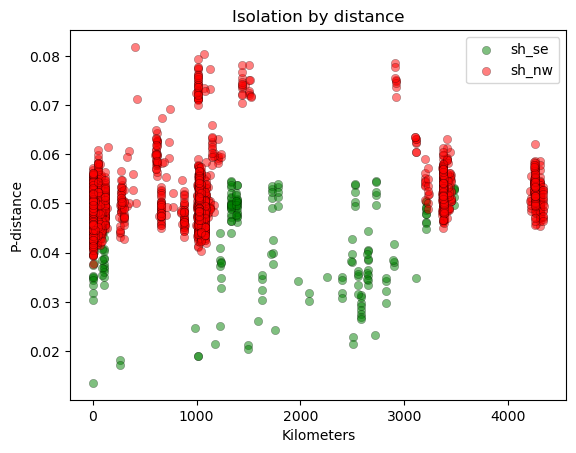

In [106]:
samples_with_geo_data = info_df.iloc[info_df['lat'].notnull().values]["sample_name"].values

for idx, color, label in [(se_idx, "green", "sh_se"),
                          (nw_idx, "red", "sh_nw") ]:
    
    #subsample genetic and physical distance matricies
    g=gen_df.iloc[idx, idx]
    k=km_df.iloc[idx, idx]

    #remove duplicate values for plotting
    mask_upper = np.triu(np.ones(g.shape)).astype(bool)
    
    g.where(~mask_upper, np.nan, inplace=True)
    k.where(~mask_upper, np.nan, inplace=True)
   
    gs=g.values.flatten()
    ks=k.values.flatten()

    gs=gs[~np.isnan(gs)]
    ks=ks[~np.isnan(ks)]

    #plot scatter plot
    plt.scatter(ks, gs, alpha=0.5, color=color, edgecolors="black", linewidth=0.3, label=label)

    
plt.legend()
plt.title("Isolation by distance")
plt.xlabel("Kilometers")
plt.ylabel("P-distance")

# Display the figure
plt.savefig("minus_sb_p-dist_vs_geo-dist.png", dpi=600, bbox_inches='tight')
plt.savefig("minus_sb_p-dist_vs_geo-dist.svg", bbox_inches='tight')


plt.show()

## Plot p-distance to a ref sample vs. lat and long

In [107]:
sh_samples = np.concatenate((sh_se_samples, sh_nw_samples))
countries=info_df.loc[info_df["sample_name"].isin(sh_samples), "country"].unique()
colors = cm.rainbow(np.linspace(0, 1, len(countries)))
country_colors = dict(zip(countries, colors))

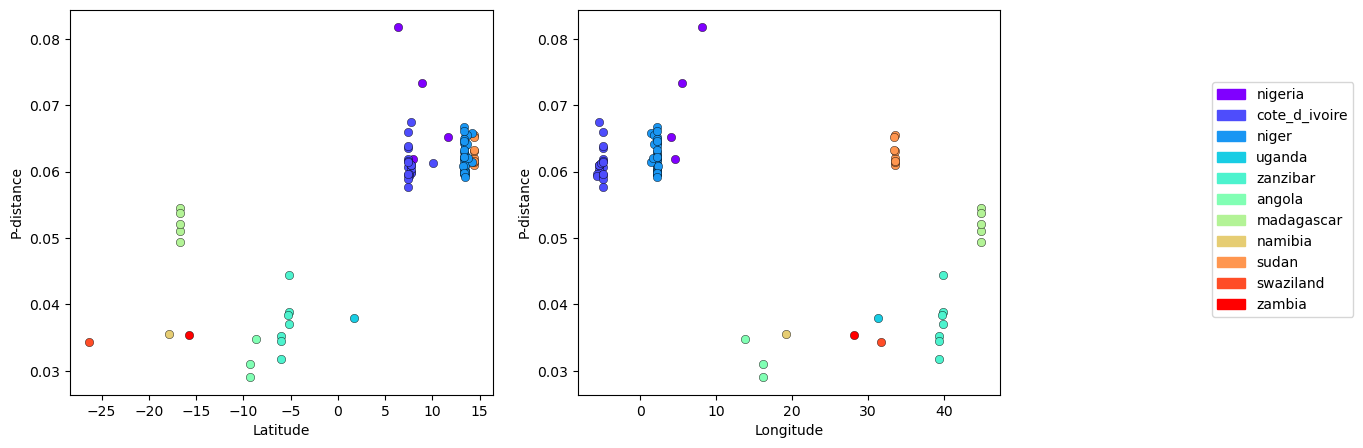

In [117]:
g = gen_df.iloc[sh_idx, sh_idx]
k = km_df.iloc[sh_idx, sh_idx]

ref_sample = "sha_unguja_kinyasini_19"
#ref_sample=info_df.iloc[info_df["lat"].astype(float).idxmin()]["sample_name"]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for Latitude
for sample, p_distance in g[ref_sample].items():
    if sample != ref_sample:
        country = info_df.loc[info_df["sample_name"] == sample, "country"].item()
        latitude = info_df.loc[info_df["sample_name"] == sample, "lat"].item()
        ax1.scatter(latitude, p_distance, color=country_colors[country], edgecolors="black", linewidth=0.3)
ax1.set_xlabel("Latitude")
ax1.set_ylabel("P-distance")

# Scatter plot for Longitude
for sample, p_distance in g[ref_sample].items():
    if sample != ref_sample:
        longitude = info_df.loc[info_df["sample_name"] == sample, "lon"].item()
        country = info_df.loc[info_df["sample_name"] == sample, "country"].item()
        ax2.scatter(longitude, p_distance, color=country_colors[country], edgecolors="black", linewidth=0.3)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("P-distance")

# Create a custom legend for the entire figure
legend_handles = [mpatches.Patch(color=country_colors[country], label=country) for country in countries]

# Positioning the legend can be done using bbox_to_anchor. 
# Here, I'm placing it outside the second subplot to the right.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.2, 0.5))


# Display the figure
plt.savefig("minus_sb_p-distance_lat_lon_gradient.png", dpi=600, bbox_inches='tight')
plt.savefig("minus_sb_p-distance_lat_lon_gradient.svg", bbox_inches='tight')


plt.show()
